In [1]:
import context

from G4EPP import api

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.colors import LogNorm

from astropy.io import fits
from astropy.time import Time, TimeMJD

from scipy import constants as const

import warnings 
warnings.filterwarnings("ignore")

#Api = api("Jupiter")

import seaborn as sns
sns.set_theme(font_scale=2)

In [2]:
def findJupiter(year, month, day):
    
    from skyfield.api import load

    planets = load('de421.bsp')
    earth, planet = planets['earth'], planets['jupiter barycenter']

    ts = load.timescale();

    jd = ts.tt(year, month, day);

    position = earth.at(jd).observe(planet)
    ra, dec, distance = position.radec()
    print("--------------------------------------")
    print("Time (UTC): {}/{}/{}\n".format(jd.utc.year, jd.utc.month, jd.utc.day))
    print("Earth-Jupiter distance %.2e km" % distance.km)
    print("Light travel time from Jupiter: %.0f sec\n" % (distance.m/299792458.0))    
    
    print("Jupiter location:\nRA: %s\nDEC: %s" % (ra, dec))

    rJ  = 71000; # km , Jupiter disk radius
    rEJ = distance.km; # km , average Earth - Jupiter distance
    omega = np.pi * rJ**2 / rEJ**2;

    factor = 1/ (4 * np.pi * (rEJ * 1000 * 100)**2); # in cm^-2

    print("\nFrom Earth, Jupiter subtends: %.2e sr" % omega);
    print("%.2f arcmin = %.2f arcsec" % (np.rad2deg(np.sqrt(omega))*60, np.rad2deg(np.sqrt(omega))*60*60));
    print("--------------------------------------\n")

    return factor;

def assembleJunoJEDIData(dataSeries, dataRange, rangeType):

    # dataRange is energy 
    if rangeType is 'lin':
        Y = np.linspace(dataRange[0], dataRange[1], len(dataSeries.keys())-1);
    elif rangeType is 'log':
        Y = np.logspace(np.log10(dataRange[0]), np.log10(dataRange[1]), len(dataSeries.keys())-1);

    X, Y = np.meshgrid(dataSeries.t, Y);
    Z = [];
    for i in range(0, len(dataSeries.keys())-1):
        dataSeries['c%d' % i][dataSeries['c%d' % i] < -1e30] = np.nan;
        Z.append(dataSeries['c%d'%i])

    return X, Y, np.array(Z);

def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [3]:
rel_v = lambda E, m0: const.c * np.sqrt(1 - (1 + E/m0)**-2);

# E in [keV], m0 in [keV/c^2]
m0_el = 511;           # keV/c^2
m0_p  = 1836 * m0_el;  # ~1800x electron mass
m0_O  = 16   * m0_p;   # 16 amu/nuc
m0_S  = 32   * m0_p;   # 32 amu/nuc

E = np.logspace(1, 5);

In [5]:
'''
fn = "P0801930701M1X000SRCTSR8001.FTZ"
hdu_t = fits.open(path1 + path + fn)

hdu_t[1].header
''';

--------------------------------------
Time (UTC): 2017/6/17

Earth-Jupiter distance 7.60e+08 km
Light travel time from Jupiter: 2535 sec

Jupiter location:
RA: 12h 50m 15.33s
DEC: -03deg 54' 26.6"

From Earth, Jupiter subtends: 2.74e-08 sr
0.57 arcmin = 34.16 arcsec
--------------------------------------



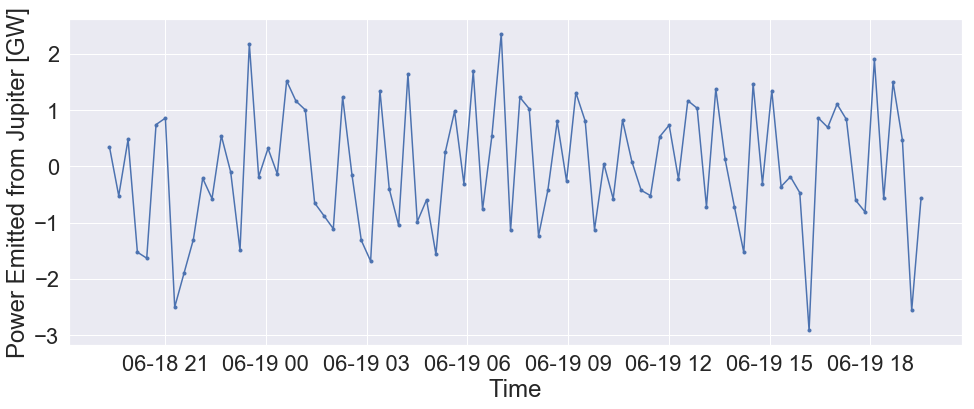

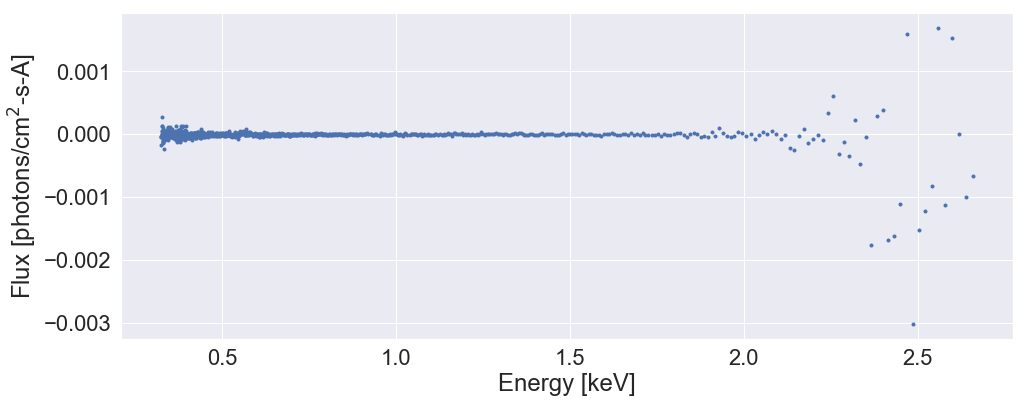

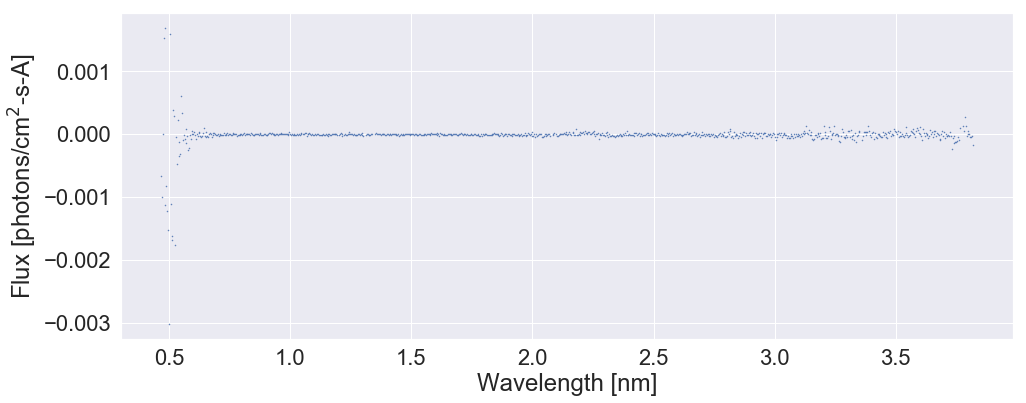

In [6]:

path1 = "/home/grant/Documents/Research/Jupiter_research/JG4_analysis/"

path = "data/XMM_Newton/0801930701/"
fn = "P0801930701R2S005SRCTSR0001.FTZ"

hdu = fits.open(path1 + path + fn);

fn = "P0801930701R1S004BGMODL1000.FTZ";
hdu_bg = fits.open(path1 + path + fn);

fn = "P0801930701RGX000FLUXED1001.FTZ";
hdu_fluxed = fits.open(path1 + path + fn);

t0 = np.datetime64('2017-06-18T20:02:51.000');
dt = np.timedelta64(1000, 's');

e_S = pd.read_pickle(path1 + "data/electron_spectra.pkl");
H_S = pd.read_pickle(path1 + "data/proton_spectra.pkl");
O_S = pd.read_pickle(path1 + "data/oxygen_spectra.pkl");
S_S = pd.read_pickle(path1 + "data/sulfur_spectra.pkl");


SOL_shift = np.timedelta64(2535, 's');

t = []
t.append(t0);
for i in range(0, 87):
    t.append(t[len(t)-1] + dt);

t = np.array(t) - SOL_shift;
factor = findJupiter(2017, 6, 18)*100;

plt.figure(figsize=(16, 6)); plt.grid(True, which='both');
plt.plot(t, hdu[1].data.RATE/factor * 1.6e-16 * 1e-9, '.-');
plt.xlabel('Time');
plt.ylabel('Power Emitted from Jupiter [GW]');

plt.figure(figsize=(16, 6)); plt.grid(True, which='both');
plt.plot(6.242e+12 * 1e3 * const.h * const.c / (hdu_fluxed[1].data.CHANNEL * 1e-10), 
         hdu_fluxed[1].data.FLUX, '.');
plt.xlabel('Energy [keV]');
plt.ylabel('Flux [photons/cm$^2$-s-A]');
#plt.yscale('log');

plt.figure(figsize=(16, 6)); plt.grid(True, which='both');
plt.plot(hdu_fluxed[1].data.CHANNEL / 10, hdu_fluxed[1].data.FLUX, '.', markersize=1);
plt.xlabel('Wavelength [nm]');
plt.ylabel('Flux [photons/cm$^2$-s-A]');
#plt.yscale('log');

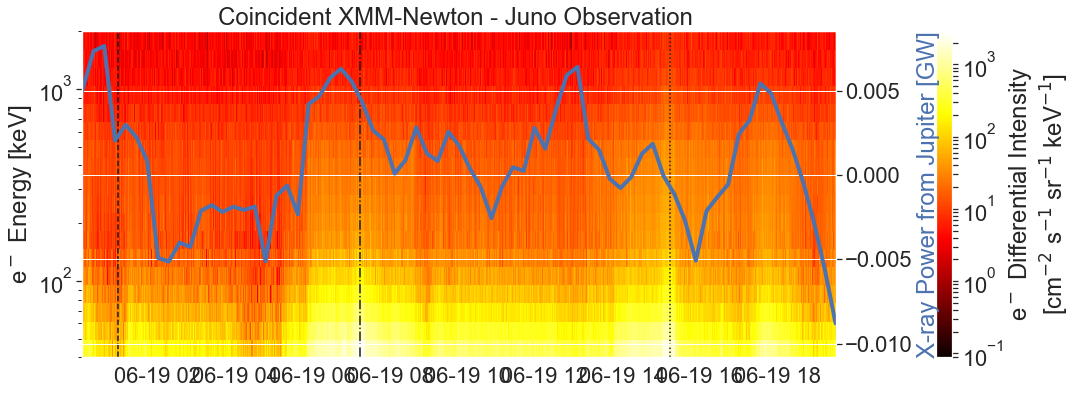

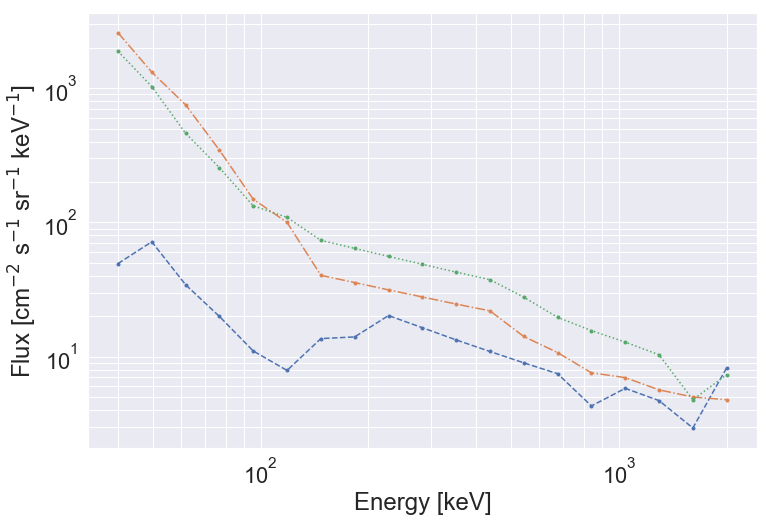

In [28]:
import matplotlib.colors as colors
from scipy.signal import savgol_filter

smoothFactor = 11

# 860 is also good
lines = [110, 860, 1820]

X, Y, Z = assembleJunoJEDIData(e_S, [4e1, 2e3], 'log')

plt.figure(figsize=(18, 6))

plt.pcolormesh(X,
               Y,
               Z,
               norm=colors.LogNorm(vmin=np.nanmin(Z), vmax=np.nanmax(Z)),
               cmap='hot')
plt.yscale('log')
c = plt.colorbar(pad=0.1)
plt.ylabel('e$^-$ Energy [keV]')
c.set_label(
    'e$^-$ Differential Intensity\n[cm$^{-2}$ s$^{-1}$ sr$^{-1}$ keV$^{-1}$]')

plt.xticks(t[0::4])

ls = ['--', 'dashdot', 'dotted']

for ind, line in enumerate(lines):
    plt.vlines(e_S.t[line], 4e1, 2e3, 'k', linestyle=ls[ind])

ax2 = plt.twinx()
#ax2.plot(t, hdu[1].data.RATE/factor * 1.6e-16 * 1e-9, '.-', label='XMM Data');
'''
ax2.plot(t,
         10**(savgol_filter(hdu[1].data.RATE / factor * 1.6e-16 * 1e-9,
                       smoothFactor, 2)/10),
         'b-',
         linewidth=4,
         label='Smoothed Series')
''';
ax2.plot(t,
         savgol_filter(hdu[1].data.RATE ,
                       smoothFactor, 2),
         'b-',
         linewidth=4,
         label='Smoothed Series')
ax2.set_ylabel('X-ray Power from Jupiter [GW]', color='b')

plt.title('Coincident XMM-Newton - Juno Observation ')
#ax2.set_yscale('log')
ax2.set_xlim(X[0, 0], t[-1])
#ax2.set_yticks([5e-1, 1e0, 2e0],["5$\times$10$^{-1}$", "10$^0$", "2$\times$10$^0$"])


plt.figure(figsize=(12, 8))
plt.grid(True, which='both')
for ind, line in enumerate(lines):
    plt.loglog(Y[:, line],
               Z[:, line],
               '.-',
               label=e_S.t[line],
               linestyle=ls[ind])
plt.xlabel('Energy [keV]')
plt.ylabel('Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ keV$^{-1}$]');